In [82]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import date, timedelta

In [3]:
epi_dir = '/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/LTACH_transmission_modeling/data'

In [ ]:
# census data
df_census = pd.read_excel(f"{epi_dir}/2019-02-25_KPCLTACH_C_Census.xlsx")
# patient level info
df_pat = pd.read_csv(f"{epi_dir}/2019-12-18_patient_isolate_date_lookup_df.csv", index_col=0)
# facility trace
df_ftrace = pd.read_csv(f"{epi_dir}/2019-12-18_facility_trace.csv", index_col=0)
df_ftrace.columns = np.arange(367)
# infections
df_inf = pd.read_excel(f"{epi_dir}/KPCLTACH_C_ClinicalMicro-2.xlsx")

### Question 0: Who is around, even?

In [123]:
df_census.head()

,WGS_ID,WGS_StudyID,Room,Bed,Admit_Date,DischargeDate,LOS,Room_Bed,From_Date,Thru_Date
0,C-1031,1031,DE/DE.2EAST,A,2012-10-16,2012-10-29,13,DE.225-A,2012-10-16,2012-10-16
1,C-1031,1031,DE/DE.2EAST,A,2012-10-16,2012-10-29,13,DE.206-A,2012-10-17,2012-10-28
2,C-1,1,DE/DE.SCU,1,2012-02-22,2012-10-23,244,DE.SC11-1,2012-09-26,2012-10-22
3,C-1,1,DE/DE.SCU,1,2012-02-22,2012-10-23,244,DE.109-B,2012-07-05,2012-07-07
4,C-1,1,DE/DE.SCU,1,2012-02-22,2012-10-23,244,DE.117-B,2012-07-08,2012-07-23


In [54]:
df_census["WGS_StudyID"].nunique()

890

In [57]:
# multiple floors and rooms possible for a patient during their stay
df_census.groupby("WGS_ID")["Room"].nunique().value_counts()

Room
1    772
2    101
3     17
Name: count, dtype: int64

In [127]:
# number of unique locations
df_census["Room"].nunique(), df_census["Room_Bed"].nunique()

(5, 148)

In [65]:
df_census2[df_census2["WGS_ID"] == "C-147"]

,WGS_ID,Admit_Date,DischargeDate
2081,C-147,2012-07-26,2012-08-23
2083,C-147,2012-09-19,2012-11-12
2087,C-147,2012-12-11,2013-01-02
2089,C-147,2013-01-17,2013-02-13
2090,C-147,2013-03-15,2013-05-08


In [134]:
# some patients make multiple visit
df_census2 = df_census[["WGS_StudyID", "Admit_Date", "DischargeDate"]].drop_duplicates()

df_census3 = df_census2[df_census2["WGS_StudyID"].isin(df_ftrace.index)]

date = df_census["Thru_Date"].min()
end_date = df_census["From_Date"].max()
delta = timedelta(days=1)
a = []
b = []
while date <= end_date:
    a.append(((df_census2["Admit_Date"] <= date) & (df_census2["DischargeDate"] > date)).sum())
    b.append(((df_census3["Admit_Date"] <= date) & (df_census3["DischargeDate"] > date)).sum())    
    date += delta


### Question 1: Who gets infected, when?

- facility trace data
- infections tally?

Facility Trace Formatting

In [6]:
df_pat["isolate.id"].nunique()

465

In [90]:
len(trace_pop)

367

In [101]:
# for each patient: track day they were admitted, day they first tested positive..?

In [165]:
trace_pop = (df_ftrace >= 1).sum(0)

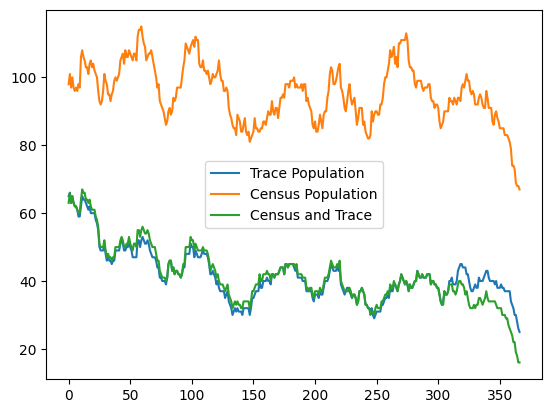

In [166]:
sns.lineplot(trace_pop, label="Trace Population")
sns.lineplot(a, label="Census Population")
sns.lineplot(b, label="Census and Trace")
plt.show()

In [6]:
df_pat["patient.id"].nunique(), df_ftrace.shape[0]
# hannah's interpretation: 4 people who didn't get sequenced for whatever reason

(255, 260)

In [7]:
df_ftrace[(df_ftrace.max(1) < 1.5)].index
# only one person never got colonized!

Index([45], dtype='int64')

In [42]:
presence = (df_ftrace > 0).astype(int)
xs = []
ys = []
for row, series in presence.iterrows():
    for col, v in series.items():
        if v == 1:
            xs.append(row)
            ys.append(col)

<Axes: >

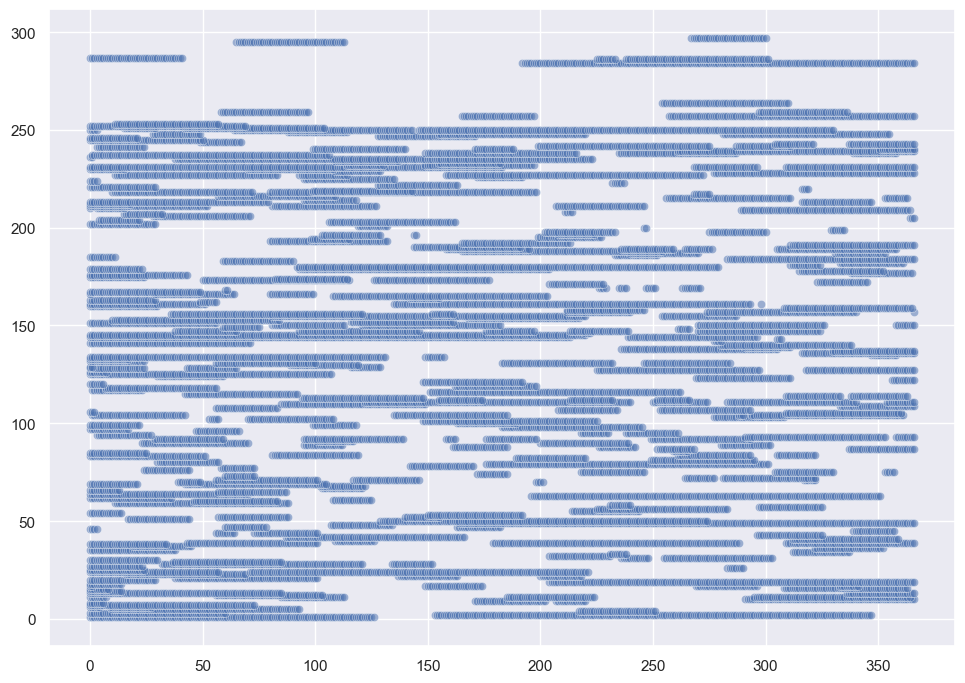

In [55]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(y = xs, x = ys, alpha=0.5)


In [148]:
df_f = df_ftrace.copy().replace(1, np.nan)
df_f = df_f.ffill(axis=1)

In [156]:
S = (df_f == 1.25).sum(0)
I = (df_f == 1.5).sum(0)

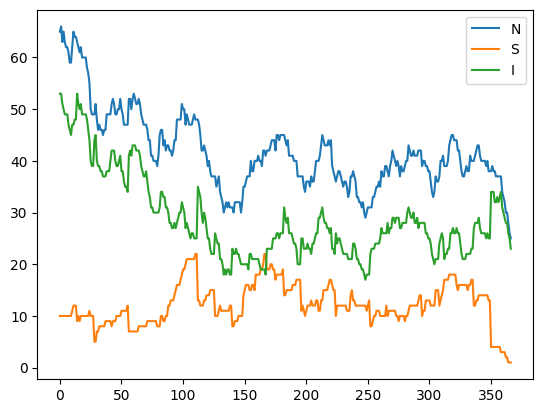

In [168]:
# raw population view
sns.lineplot(trace_pop, label="N")
sns.lineplot(S, label="S")
sns.lineplot(I, label="I")
plt.show()

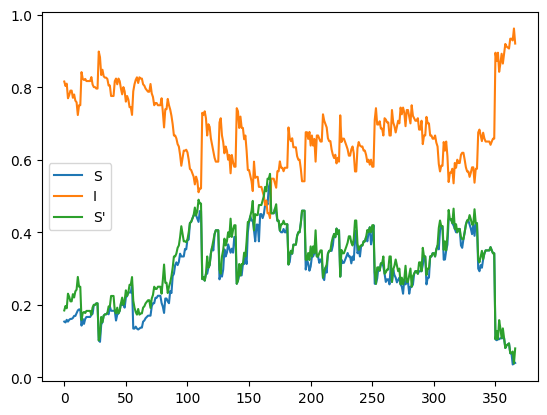

In [171]:
sns.lineplot(S / trace_pop, label="S")
sns.lineplot(I / trace_pop, label="I")
sns.lineplot(1 - (I / trace_pop), label="S'")
plt.show()

In [187]:
df_ftrace[df_ftrace > 0].bfill(axis=1)[0].value_counts()

0
1.00    115
1.50     89
1.25     56
Name: count, dtype: int64

In [198]:
89 / (89 + 56)

0.6137931034482759

In [197]:
df_ftrace[df_ftrace > 1].bfill(axis=1)[0].value_counts()

0
1.50    144
1.25    116
Name: count, dtype: int64

In [199]:
144 / (144 + 116)

0.5538461538461539

In [182]:
(df_ftrace > 0).any(axis=1)

1      True
2      True
3      True
4      True
5      True
       ... 
284    True
286    True
287    True
295    True
297    True
Length: 260, dtype: bool

In [226]:
np.empty(10)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [228]:
len(df_ftrace)

260

In [232]:
entry_time = dict()
test_time = dict()
for i, r in df_ftrace[df_ftrace > 0].iterrows():
    entry_time[i] = r.first_valid_index()
    test_time[i] = r[r > 1].first_valid_index()
entry_time = pd.Series(entry_time)
test_time = pd.Series(test_time)

In [234]:
# 90% of people get tested within their first day or two...how does this inform the model?
(test_time - entry_time).value_counts()

0     145
1      93
2       7
3       4
13      2
11      2
14      1
7       1
4       1
22      1
5       1
8       1
12      1
Name: count, dtype: int64

In [236]:
# how many novel infections?


0.9153846153846154

# Old Data Processing

Colonization on arrival

In [12]:
n = df_ftrace.shape[0]
intake_data = {"patient":[], "crkp":[], "date":[]}

In [ ]:
# loop through patients
for i in range(n):
    admitted = False
    for t in df_ftrace.columns:
        # what is the date they enter the facility?
        if df_ftrace.iloc[i, c] != 0:
            # if they have a positive test result upon intake, they count as infected
            # if they have a negative test or no test upon intake, they do not
            intake_data["crkp"][i] = int(df_ftrace.iloc[i, t] == 1.5)
            intake_data["date"][i] = t
            break
intake_data = pd.DataFrame(intake_data, index=df_ftrace.index)

In [71]:
admitted = False
statuses = {"patient": [], "crkp": [], "date": []}
for t, val in sample.items():
    if not admitted and (val > 0):
        admitted = True
        statuses["patient"].append(11)
        statuses["crkp"].append(int(val == 1.5))
        statuses["date"].append(t)
    if admitted and (val == 0):
        admitted = False


In [12]:
intake_data.to_csv("/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/network/intake_data.csv")

15509 corresponds to June 18th, 2012..

Infections Formatting

In [17]:

# df_inf = df_inf[(df_inf["ORG"]=="Klebsiella pneumoniae") & (df_inf["Carbapenem_R"] == 1)]
df_inf = df_inf[(df_inf["ORG"]=="Klebsiella pneumoniae")]
df_inf = df_inf[["WGS_StudyID", "CollectDate", "Carbapenem_R"]]
df_inf = df_inf[df_inf["CollectDate"] > datetime.datetime(2012, 6, 18)]
df_inf = df_inf.set_index("WGS_StudyID").join(df_ftrace[0], how="inner")

In [18]:
df_inf.head()

,CollectDate,Carbapenem_R,0
1,2012-07-05,1,1.5
1,2012-07-17,1,1.5
1,2012-08-23,1,1.5
2,2013-03-15,0,0.0
3,2012-08-05,1,1.5


In [19]:
df_inf["test_time"] = df_inf["CollectDate"] - datetime.datetime(2012, 6, 18)
df_inf["test_time"] = df_inf["test_time"].dt.days
df_inf.drop(columns=[0], inplace=True)

In [26]:
df_inf_raw = pd.read_excel(f"{epi_dir}/KPCLTACH_C_ClinicalMicro-2.xlsx")

In [24]:
df_inf.to_csv("/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/network/infections.csv")